This script (Python 3) loads large dimensional neural data, performs minor operations (normalization, etc), and provides an interactive visualization by the end to explore time-frequency domain functional coupling between signals recorded brain regions. Go to bottom of the notebook for interactive visualization.

In [24]:
import h5py
import numpy as np
import scipy
import os

import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')
import pandas as pd
import seaborn as sns
%matplotlib notebook

#from __future__ import print_function
from ipywidgets import interactive
import ipywidgets as widgets
from IPython.display import display, clear_output
from traitlets import CInt, link
import time
import matplotlib.gridspec as gridspec

In [5]:
## Helper functions

class Timer:    
    
    def __init__(self, label):
        self.label = label
        
    def __enter__(self):
        self.start = time.clock()
        return self

    def __exit__(self, *args):
        self.end = time.clock()
        self.interval = self.end - self.start
        print(self.label,"- took %.06f sec" % self.interval)
        
def fileHandle(session):
    # Set up file locations
    fileHandle = {}
    fileHandle['dataDir'] = 'C:\\Users\\jian\\Documents\offlineResult'
    fileHandle['session'] = session
    fileHandle['suDir']   = session+'-SPK-SU'
    fileHandle['lfpDir']  = session+'-LFP'
    fileHandle['suFileNamePrefix'] = 'SPK-SUDelayOnsetTime[-1350  1650]-'
    fileHandle['fileFormat'] = '.mat'
    fileHandle['infoSummary'] = 'summary'  
    fileHandle['lfpFileNamePrefix'] = 'LFP-Freq[1  500]-DelayOnsetTime[-1350  1650]-'
    return fileHandle


In [9]:
## Read files and obtain relevant meta info.

session = 'JS20131010'
file = fileHandle(session)
spectralMetaInfoFileName = os.path.join(file['dataDir'],file['session'],file['lfpDir'],
                                        file['lfpFileNamePrefix']+"spectral-metaInfo"+file['fileFormat'])
print(spectralMetaInfoFileName)

with Timer("Open file") as t:
    metaFile = h5py.File(spectralMetaInfoFileName)
    #f = h5py.File(r'C:\Users\jian\Documents\offlineResult\CS20120918\CS20120918-LFP\LFP-Freq[1  500]-DelayOnsetTime[-1350  1650]-tar1-spectral.mat','r')

Epochs = metaFile["Epochs"]

tar = 1
spectralFileName = os.path.join(file["dataDir"],file["session"],file["lfpDir"],
    file["lfpFileNamePrefix"]+"tar"+str(tar)+"-spectral"+file["fileFormat"])
print(spectralFileName)
sFile = h5py.File(spectralFileName)

ch2ch = sFile["ch2ch"][:]

sfWins = sFile["spikeFieldWindows"][:]
#print(sfWins)

In [11]:
## Set area, frequency and time labels.

# Area labels for subject J
areaLabels = ["" for x in np.arange(0,96,1)]
areaLabels[15] = "SEF"
areaLabels[15+32] = "FEF"
areaLabels[15+32+32] = "PFC"

freqBands = {
            'delta': [1,4],
            'theta': [4,8],
            'alpha': [8,12],
            'beta': [15, 30],
            'low gamma':[30, 60],
            'high gamma':[60, 80],
            'all' : [0,81]
            }

measure_cm = sns.cubehelix_palette(rot=-.4, dark = .1, light=1,reverse=False,as_cmap=True)
measure_cm_r = sns.cubehelix_palette(rot=-.4, dark = .1, light=1,reverse=True,as_cmap=True)

def setFreqLabels(fLo, fHi, freqs, fStep = 5, end = True):
# select frequency of interest
# returns fRange  ~ index in freqs covering [fLo fHi]
# and     fLabels ~ labels corresponding to int values of
#                   freqs[fRange] in fStep increments
    
    fLoInd = np.argmax(freqs >= fLo)
    fHiInd = np.argmax(freqs >= fHi)
    fRange = np.arange(fLoInd,fHiInd,1)
    fLabels = [ str(int(round(freqs[x]))) if (x in np.arange(fLoInd, fHiInd, fStep)) else " " for x in fRange]
    if end == True:
        fLabels[-1] = str(int(round(freqs[fRange[-1]])))
    return (fRange,fLabels)


# Frequency band selection widget
freqBand_button = widgets.ToggleButtons(
    options = [key for key in sorted(freqBands, key = lambda x: freqBands[x][1])],
    value = "beta"
)
 
ylabels = []
ylabels = [ str(int(sFile["f"][x])) if x%7 == 0 else " " for x in np.arange(0,sFile["f"][:].size,1)]
 

xlabels = ["" for x in metaFile["windowStartInd"]]

##  Generate epoch labels for windows centered around epoch beginning
for key in metaFile["Epochs"].keys():
    temp = abs(metaFile["windowStartInd"][:]+ np.asarray(metaFile["nfft"])*.5 - metaFile["Epochs"][key][1])
    xlabels[temp.argmin()] = key
 
fixationStart = xlabels.index("fixation")  # Index of fixation start, used for labeling and truncating spectrograms, etc
responseEnd = xlabels.index("response")+7  # Index of response end (400 ms), used for labeling and truncating spectrograms, etc

sfWinLabels = ["" for x in sfWins]

for key in metaFile["Epochs"].keys():
    temp = abs(sfWins+50 - metaFile["Epochs"][key][1])
    sfWinLabels[temp.argmin()] = key
 
    
fLo = 1
fHi = 100
(fRange, fLabels) = setFreqLabels(fLo, fHi,sFile["f"][:] )

In [15]:
## Set spike-field related parameters and traitlet for visualization

nUnits = metaFile["chNumUnits"][:].sum()

unit2Ch = np.asarray([ 0 for x in np.arange(0,nUnits,1)])
unit2ChUnit = np.asarray([ 0 for x in np.arange(0,nUnits,1)])

unitCount = 0

for ch in metaFile["spkChs"][:]:
    unit2Ch[unitCount:unitCount+metaFile["chNumUnits"][0,ch-1]] = ch
    unitCount +=  metaFile["chNumUnits"][0,ch-1]
#print(unit2Ch)

class Counter(widgets.DOMWidget):
    value = CInt(1).tag(sync=True)

# Decalre unit manipulation widgets
unitCounter = Counter()
def unitPlus_button(name):
    unitCounter.value += 1 if unitCounter.value < nUnits else 0
def unitMinus_button(name):
    unitCounter.value -= 1 if unitCounter.value > 1 else 0
    
unitPlus = widgets.Button(description = '>', width = 30)
unitMinus = widgets.Button(description = '<', width = 30)
unitSlider = widgets.IntSlider(value = 3, min = 1, max = nUnits,description = "unit", width = 300)
unitPlus.on_click(unitPlus_button)
unitMinus.on_click(unitMinus_button)
# Note: link cannot work with interactive element since no 'value' trait is availabe
link((unitSlider,'value'),(unitCounter,'value'))

# Target direction selection button 
targetSelection_button = widgets.ToggleButtons(
    description = "Target",
    options = [1,2,3,4,5,6],
    value = 1
)
tar = 1

sFileName = os.path.join(file["dataDir"],file["session"],file["lfpDir"],
        file["lfpFileNamePrefix"]+"tar"+str(tar)+"-spectral"+file["fileFormat"])
tempSFile = h5py.File(sFileName)
unit = unitSlider.value - 1

# Plot button for SF measures
unitButton = widgets.Button(description ="plot spike-field", width = 10)
anova_cm = sns.cubehelix_palette(rot=.4, dark = .1, light=1,reverse=False,as_cmap=True)
anova_cm_r = sns.cubehelix_palette(rot=.4, dark = .1, light=1,reverse=True,as_cmap=True)
    
sfFLo = 1
sfFHi = 80
(sfFRange, sfFLabels) = setFreqLabels(sfFLo, sfFHi,sFile["f"][1:] )

# Plot button action for SF measures
def unit_on_button_clicked(b):   
    
    def add_epoch_and_channel_lines():
        ## Add epoch lines (white) and channel line (green)
        plt.axvline(x = sfWinLabels.index("fixation"), color = ".8")
        plt.axvline(x = sfWinLabels.index("target"), color = '.8')
        plt.axvline(x = sfWinLabels.index("delay"), color = '.8')
        plt.axvline(x = sfWinLabels.index("response"), color = '.8')
        #plt.axhline(y = 95-chInd, color = 'g', lw = 2)
        
    unit = unitSlider.value - 1
    unitCh = unit2Ch[unit]
    clear_output()
    #print("Ch", ch+1,"selected")
    
    tar = targetSelection_button.value
    sFileName = os.path.join(file["dataDir"],file["session"],file["lfpDir"],
        file["lfpFileNamePrefix"]+"tar"+str(tar)+"-spectral"+file["fileFormat"])
    # print(spectralFileName)
    tempSFile = h5py.File(sFileName)
    plv_data = (np.transpose((tempSFile["spikeFieldPLV"][:,unit,sfFRange])))
    ppc_data = (np.transpose((tempSFile["spikeFieldPPC"][:,unit,sfFRange])))
    sfc_data = (np.transpose((tempSFile["spikeFieldCoherence"][:,unit,sfFRange])))
    spk_data = tempSFile["nSpikesPerUnitPerWindow"][:, unit]
    tempSFile.close()

    
    ## Reset figure 
    ##(has to clear entire figure because seaborn heatmap generates one more axis for colormap per subplot)
    plt.figure(fSF.number)
    plt.clf()
    gs = gridspec.GridSpec(9,12)
    axPLV = plt.subplot(gs[0:5,0:4])
    axPPC = plt.subplot(gs[0:5,4:8])
    axSFC = plt.subplot(gs[0:5,8:])
    axNS = plt.subplot(gs[6:,:])
       
    ## Plot phase locking values
    plt.sca(axPLV)
    plv_plot = sns.heatmap(plv_data, vmin = plv_data.min(), vmax = plv_data.max() ,robust=True,cmap= measure_cm, 
                           yticklabels = sfFLabels, xticklabels = sfWinLabels, ax = axPLV)
    plv_plot.invert_yaxis()
    plv_plot.tick_params(axis='x',labelsize=9)
    plv_plot.set_ylabel("Frequency (Hz)", fontsize = 10)
    plv_plot.set_title("".join(['PLV']), fontsize = 10)
    add_epoch_and_channel_lines()
    
    ## Plot pairwise phase consistency
    plt.sca(axPPC)
    ppc_plot = sns.heatmap(ppc_data, cbar = False,#vmin = ppc_data.min(), vmax = ppc_data.max() ,
                                cmap = measure_cm, yticklabels =[], xticklabels = sfWinLabels, ax = axPPC)
    ppc_plot.invert_yaxis()
    cbar = ppc_plot.figure.colorbar(ppc_plot.collections[0])
    cbar.set_ticks([-.5,0,.5])
    cbar.set_ticklabels(["-.5","0",".5"])
    ppc_plot.tick_params(axis = 'x', labelsize=9)
    ppc_plot.set_title("".join(["PPC"]), fontsize = 10)
    add_epoch_and_channel_lines()
    
    ## Plot spike field coherence
    plt.sca(axSFC)
    sfc_plot = sns.heatmap(sfc_data, vmin = sfc_data.min(), vmax = sfc_data.max() , robust = True,
                                cmap = measure_cm, yticklabels =[], xticklabels = sfWinLabels, ax = axSFC)
    sfc_plot.invert_yaxis()
    sfc_plot.tick_params(axis = 'x', labelsize=9)
    sfc_plot.set_title("".join(["SFC, unit #", str(unit+1), ", ch ", str(unitCh),", tar ", str(tar)]), fontsize = 10)
    add_epoch_and_channel_lines()
    
    ## plot # of spikes in bin
    plt.sca(axNS)
    ns_plot = plt.bar(np.arange(0,len(sfWinLabels),1), spk_data, tick_label = sfWinLabels)
    plt.ylabel("Spike count", fontsize = 10)
    plt.title("Unit #"+ str(unit+1)+ ", ch "+ str(unitCh)+ ", tar " + str(tar))
    add_epoch_and_channel_lines()
    
    
unitButton.on_click(unit_on_button_clicked)

In [19]:
## Field-field visualization widgets 
class Counter(widgets.DOMWidget):
    value = CInt(1).tag(sync=True)

chCounter = Counter()
def plus_button(name):
    chCounter.value += 1 if chCounter.value < 96 else 0
def minus_button(name):
    chCounter.value -= 1 if chCounter.value > 1 else 0
    
chPlus = widgets.Button(description = '>', width = 30)
chMinus = widgets.Button(description = '<', width = 30)
# selectCh = interactive(printChSelection, channel = (1,96),continuous_update=False)
chSlider = widgets.IntSlider(value = 0, min = 1, max = 96,description = "channel", width = 300)
chPlus.on_click(plus_button)
chMinus.on_click(minus_button)
## Note: link cannot work with interactive element since no 'value' trait is availabe
link((chSlider,'value'),(chCounter,'value'))


button = widgets.Button(description ="plot PSD", width = 10)
pValThreshold_PS = .01

expVarFileName = os.path.join(file["dataDir"],file["session"],file["lfpDir"],
    file["lfpFileNamePrefix"]+"expVar"+file["fileFormat"])
expVarFile = h5py.File(expVarFileName)

def on_button_clicked(b): 
    def add_epoch_and_channel_lines():
        ## Add epoch lines (white) and channel line (green)
        truncatedXLabels = xlabels[fixationStart:responseEnd]
        plt.axvline(x = truncatedXLabels.index("fixation"), color = ".8")
        plt.axvline(x = truncatedXLabels.index("target"), color = '.8')
        plt.axvline(x = truncatedXLabels.index("delay"), color = '.8')
        plt.axvline(x = truncatedXLabels.index("response"), color = '.8')
    
    ch = chSlider.value - 1
    clear_output()
    #print("Ch", ch+1,"selected")
    
    ps_data = (np.transpose((sFile["powerSpectrum"][:,ch,:])))

    ## Transform power into decibel
    ps_data = 10*np.log10(ps_data/ps_data.min())

    ## Reset figure 
    ##(has to clear entire figure because seaborn heatmap generates one more axis for colormap per subplot)
    plt.figure(fPS.number)
    plt.clf()
    gs = gridspec.GridSpec(6,12)
    axPS = plt.subplot(gs[:,0:4])
    axPSANOVA = plt.subplot(gs[:,4:8])
    axPSPVal = plt.subplot(gs[:,8:])
    
    ## Plot power spectrum values
    plt.sca(axPS)
    ps_plot = sns.heatmap(ps_data[:,fixationStart:responseEnd], vmin = ps_data.min(), vmax = ps_data.max(),robust=True,cmap=measure_cm, yticklabels = ylabels,
                                xticklabels = xlabels[fixationStart:responseEnd], ax = axPS)
    ps_plot.invert_yaxis()
    ps_plot.tick_params(axis='x',labelsize=9)
    add_epoch_and_channel_lines()
    ps_plot.set_ylabel("Frequency (Hz)", fontsize = 10)
    ps_plot.set_title("".join(['Power spectrum']), fontsize = 10)
    
    ## Plot percent explained variance of coherence
    #plt.figure(3)
    plt.sca(axPSANOVA)

    
    psExpVar_data = 100*(np.transpose((expVarFile["psExpVar"][:, ch,:])))
    psExpVar_data = psExpVar_data[0:len(ylabels),:]
    psExpVar_plot = sns.heatmap(psExpVar_data[:,fixationStart:responseEnd], vmin = psExpVar_data.min(), vmax = psExpVar_data.max(), robust = True,
                                cmap = anova_cm, yticklabels =[], xticklabels = xlabels[fixationStart:], ax = axPSANOVA)
    psExpVar_plot.invert_yaxis()
    psExpVar_plot.tick_params(axis = 'x', labelsize=9)
    add_epoch_and_channel_lines()
    psExpVar_plot.set_title("".join(["Explained variance, ch ", str(ch+1)]), fontsize = 10)
    
    ## Plot P-value of variance of coherence
    #plt.figure(4)
    plt.sca(axPSPVal)

    psPVal_data = (np.transpose((expVarFile["psPVal"][:, ch,:])))
    psPVal_data = psPVal_data[0:len(ylabels),:]
    psPVal_plot = sns.heatmap(psPVal_data[:,fixationStart:responseEnd], vmin = psPVal_data.min(), vmax = pValThreshold_PS, robust = True,
                                cmap = anova_cm_r, yticklabels = [], xticklabels = xlabels[fixationStart:], ax = axPSPVal)
    psPVal_plot.invert_yaxis()
    psPVal_plot.tick_params(axis = 'x', labelsize=9)
    add_epoch_and_channel_lines()
    psPVal_plot.set_title("".join(["P-value (ANOVA)"]), fontsize = 10)

    
button.on_click(on_button_clicked)

class Counter(widgets.DOMWidget):
    value = CInt(1).tag(sync=True)

psExpVarAllChCounter = Counter()
def psExpVarAllChCounter_plus_button(name):
    psExpVarAllChCounter.value += 1 if psExpVarAllChCounter.value < 96 else 0
def psExpVarAllChCounter_minus_button(name):
    psExpVarAllChCounter.value -= 1 if psExpVarAllChCounter.value > 1 else 0
    
psExpVarAllChPlus = widgets.Button(description = '>', width = 30)
psExpVarAllChMinus = widgets.Button(description = '<', width = 30)


# selectCh = interactive(printChSelection, channel = (1,96),continuous_update=False)
psExpVarAllChCounter_slider = widgets.IntSlider(value = 0, min = 1, max = 96,description = "channel", width = 300)

psExpVarAllChPlus.on_click(psExpVarAllChCounter_plus_button)
psExpVarAllChMinus.on_click(psExpVarAllChCounter_minus_button)

## Note: link cannot work with interactive element since no 'value' trait is availabe
link((psExpVarAllChCounter_slider,'value'),(psExpVarAllChCounter,'value'))



In [20]:
def printChPairSelection(channel, to):
    clear_output()
    print("Channel", str(int(channel)),"-> channel", str(int(to)))


fromChCounter = Counter()
toChCounter = Counter()

def plusFromCh(name):
    fromChCounter.value += 1 if fromChCounter.value < 95 else 0
def minusFromCh(name):
    fromChCounter.value -= 1 if fromChCounter.value > 1 else 0
    
def plusToCh(name):
    toChCounter.value += 1 if toChCounter.value < 96 else 0
def minusToCh(name):
    toChCounter.value -= 1 if toChCounter.value > 2 else 0
    
fromChPlus_button = widgets.Button(description = '>', width = 30)
fromChMinus_button = widgets.Button(description = '<', width = 30)
toChPlus_button = widgets.Button(description = '>', width = 30)
toChMinus_button = widgets.Button(description = '<', width = 30)

# selectCh = interactive(printChSelection, channel = (1,96),continuous_update=False)
fromCh_slider = widgets.IntSlider(value = 44,min = 1, max = 95,description = "channel", width = 300)
toCh_slider = widgets.IntSlider(value = 45, min = 2, max = 96,description = "to", width = 300)

fromChPlus_button.on_click(plusFromCh)
fromChMinus_button.on_click(minusFromCh)
toChPlus_button.on_click(plusToCh)
toChMinus_button.on_click(minusToCh)

#def print_fromChSelection(*args):
#    clear_output()
#    print("Ch", chSlider.value,"selected")

#chSlider.observe(printChPairSelection,'value')

## Note: link cannot work with interactive element since no 'value' trait is availabe
link((fromCh_slider,'value'),(fromChCounter,'value'))
link((toCh_slider,'value'),(toChCounter,'value'))

def update_toCh_slider_min(*args):
    toCh_slider.min = 1 + fromCh_slider.value

fromCh_slider.observe(update_toCh_slider_min,'value')

#interact(printChPairSelection, channel = fromCh_widget, to = toCh_widget, continuous_update=True)

In [28]:
coh_button = widgets.Button(description ="plot coherence", width = 10)
pValThreshold = .01 # Threshold for significant p-value

def on_button_clicked_plot_coherence(b):
    def add_epoch_and_channel_lines():
        ## Add epoch lines (white) and channel line (green)
        plt.axvline(x = xlabels.index("fixation"), color = ".8")
        plt.axvline(x = xlabels.index("target"), color = '.8')
        plt.axvline(x = xlabels.index("delay"), color = '.8')
        plt.axvline(x = xlabels.index("response"), color = '.8')
        
        
    fromCh = fromCh_slider.value 
    toCh = toCh_slider.value 
    chPairInd = np.asarray((ch2ch[:,0]==fromCh)*(ch2ch[:,1] == toCh)).argmax()

    
    ## Reset figure 
    ##(has to clear entire figure because seaborn heatmap generates one more axis for colormap per subplot)
    plt.figure(f.number)
    plt.clf()
    axCoh = plt.subplot(331)
    axCohANOVA = plt.subplot(332)
    axCohPVal = plt.subplot(333)
    axPLIu = plt.subplot(334)
    axPPC = plt.subplot(335)
    axPLV = plt.subplot(336)
    axWPLI = plt.subplot(337)
    axWPLIu = plt.subplot(338)
    
    ## Plot coherence values
    plt.sca(axCoh)
    coh_plot = sns.heatmap((np.transpose((sFile["coherence"][:,chPairInd,fRange]))),cmap=measure_cm, yticklabels = fLabels,
                                xticklabels = xlabels, ax = axCoh)
    coh_plot.invert_yaxis()
    coh_plot.tick_params(axis='x',labelsize=10)
    coh_plot.set_ylabel("Frequency (Hz)", fontsize = 10)
    coh_plot.set_title("".join(['Coherence ch ', str(fromCh),' <-> ', str(toCh)]), fontsize = 10)
    add_epoch_and_channel_lines()
    
    ## Plot percent explained variance of coherence
    plt.sca(axCohANOVA)
    cohExpVar_plot = sns.heatmap(100*(np.transpose((expVarFile["coExpVar"][:, chPairInd,fRange]))),cmap = measure_cm, yticklabels = fLabels, xticklabels = xlabels, ax = axCohANOVA)
    cohExpVar_plot.invert_yaxis()
    cohExpVar_plot.tick_params(axis = 'x', labelsize=8)
    #cohExpVar_plot.set_ylabel("Frequency (Hz)", fontsize = 10)
    cohExpVar_plot.set_title("".join(["Explained variance, ch ", str(fromCh)," <-> ", str(toCh)]), fontsize = 10)
    add_epoch_and_channel_lines()
    
    ## Plot P-value of variance of coherence
    #plt.figure(4)
    plt.sca(axCohPVal)
    cohPVal_plot = sns.heatmap((np.transpose((expVarFile["coPVal"][:, chPairInd,fRange]))), vmax = pValThreshold,
                                cmap = measure_cm_r, yticklabels = fLabels, xticklabels = xlabels, ax = axCohPVal)
    cohPVal_plot.invert_yaxis()
    cohPVal_plot.tick_params(axis = 'x', labelsize=8)
    #cohPVal_plot.set_ylabel("Frequency (Hz)", fontsize = 10)
    cohPVal_plot.set_title("".join(["P-value of coherence variance, ch ", str(fromCh)," <-> ", str(toCh)]), fontsize = 10)
    add_epoch_and_channel_lines()
    
    ## Plot unbiased phase lag index
    plt.sca(axPLIu)
    PLIu_plot = sns.heatmap((np.transpose((sFile["phaseLagIndex2unbiased"][:, chPairInd,fRange]))),
                            vmin = 0,cmap = measure_cm, yticklabels = fLabels, xticklabels = xlabels, ax = axPLIu)
    PLIu_plot.invert_yaxis()
    PLIu_plot.tick_params(axis = 'x', labelsize=8)
    #cohExpVar_plot.set_ylabel("Frequency (Hz)", fontsize = 10)
    PLIu_plot.set_title("".join(["PLI unbiased, ch ", str(fromCh)," <-> ", str(toCh)]), fontsize = 10)
    add_epoch_and_channel_lines()
    
    ## Plot pairwise phase consistency
    plt.sca(axPPC)
    PPC_plot = sns.heatmap((np.transpose((sFile["pairwisePhaseConsistency"][:, chPairInd,fRange]))),
                           vmin = 0,cmap = measure_cm, yticklabels = fLabels, xticklabels = xlabels, ax = axPPC)
    PPC_plot.invert_yaxis()
    PPC_plot.tick_params(axis = 'x', labelsize=8)
    PPC_plot.set_title("".join(["PPC, ch ", str(fromCh)," <-> ", str(toCh)]), fontsize = 10) 
    add_epoch_and_channel_lines()
    
    ## Plot phase locking value
    plt.sca(axPLV)
    PLV_plot = sns.heatmap((np.transpose((sFile["phaseLockingValue"][:, chPairInd,fRange]))),
                           vmin = 0,cmap = measure_cm, yticklabels = fLabels, xticklabels = xlabels, ax = axPLV)
    PLV_plot.invert_yaxis()
    PLV_plot.tick_params(axis = 'x', labelsize=8)
    #cohExpVar_plot.set_ylabel("Frequency (Hz)", fontsize = 10)
    PLV_plot.set_title("".join(["PLV, ch ", str(fromCh)," <-> ", str(toCh)]), fontsize = 10)
    add_epoch_and_channel_lines()
    
    ## Plot weighted phase lag index
    plt.sca(axWPLI)
    WPLI_plot = sns.heatmap((np.transpose((sFile["weightedPhaseLagIndex"][:, chPairInd,fRange]))),
                            vmin = 0,cmap = measure_cm, yticklabels = fLabels, xticklabels = xlabels, ax = axWPLI)
    WPLI_plot.invert_yaxis()
    WPLI_plot.tick_params(axis = 'x', labelsize=8)
    #cohExpVar_plot.set_ylabel("Frequency (Hz)", fontsize = 10)
    WPLI_plot.set_title("".join(["WPLI, ch ", str(fromCh)," <-> ", str(toCh)]), fontsize = 10)
    add_epoch_and_channel_lines()
    
    ## Plot unbiased weighted phase lag index
    plt.sca(axWPLIu)
    WPLIu_plot = sns.heatmap((np.transpose((sFile["weightedPhaseLagIndex2debiased"][:, chPairInd,fRange]))),
                             vmin = 0, cmap = measure_cm, yticklabels = fLabels, xticklabels = xlabels, ax = axWPLIu)
    WPLIu_plot.invert_yaxis()
    WPLIu_plot.tick_params(axis = 'x', labelsize=8)
    #cohExpVar_plot.set_ylabel("Frequency (Hz)", fontsize = 10)
    WPLIu_plot.set_title("".join(["WPLI debiased, ch ", str(fromCh)," <-> ", str(toCh)]), fontsize = 10)
    add_epoch_and_channel_lines()
    
coh_button.on_click(on_button_clicked_plot_coherence)


In [25]:
couplingMeasures = {
    "Coherence" : "coherence",
    "PPC" : "pairwisePhaseConsistency",
    "PLV" : "phaseLockingValue",
    "WPLI": "weightedPhaseLagIndex",
    "uPLI": "phaseLagIndex2unbiased",
    "WPLId": "weightedPhaseLagIndex2debiased",
}
couplingMeasuresExpVar = {
    "Coherence" : "coExpVar",
    "PPC" : "ppcExpVar",
    "PLV" : "plvExpVar",
    "WPLI": "wpliExpVar",
    "uPLI": "pli2uExpVar",
    "WPLId": "wpli2dExpVar",
}
ch2AllChs_button = widgets.Button(description ="collapsed array view", width = 10)

def ch2AllChs_on_button_clicked(b): 
    ## Plot statistics of selected channel to all other channels.
    ## Measures are normalized by its Frobenius norm in trial
    def add_epoch_and_channel_lines(chInd):
        ## Add epoch lines (white) and channel line (green)
        
        truncatedXLabels = xlabels[fixationStart:responseEnd]
        plt.axvline(x = truncatedXLabels.index("fixation"), color = "w")
        plt.axvline(x = truncatedXLabels.index("target"), color = 'w')
        plt.axvline(x = truncatedXLabels.index("delay"), color = 'w')
        plt.axvline(x = truncatedXLabels.index("response"), color = 'w')
        plt.axhline(y = 95-chInd, color = 'g', lw = 2)
    
    ch = chSlider.value
    lowerChInds =np.asarray(np.where( ch2ch[:,1] == ch )).flatten()
    higherChInds =np.asarray(np.where( ch2ch[:,0] == ch )).flatten()
    [fLo, fHi] = freqBands[freqBand_button.value]
    (allChsFRange, allChsFLabels) = setFreqLabels(fLo, fHi,sFile["f"][:] )
    clear_output()

    ## Reset figure 
    ##(has to clear entire figure because seaborn heatmap generates one more axis for colormap per subplot)
    plt.figure(fAllChs.number)
    plt.clf()  
    count = 1
    for key in couplingMeasures.keys():
    
        ## Plot each coupling measure
        curAxis = plt.subplot(4,3,count)
        plt.sca(curAxis)
        data =  np.sum(np.transpose(sFile[couplingMeasures[key]][:, np.hstack((lowerChInds, higherChInds)) ,:])[allChsFRange,:,:] , axis = 0)

        dataNormed = data/np.linalg.norm(data,axis = -1)[:,np.newaxis]

        curPlot = sns.heatmap(dataNormed[fixationStart:responseEnd,:], cmap=measure_cm, 
                              xticklabels = xlabels[fixationStart:responseEnd], yticklabels = areaLabels, ax = curAxis)
        curPlot.tick_params(axis='x',labelsize=10)
        curPlot.tick_params(axis = 'y', labelsize=10)
        curPlot.set_title("".join([key,', ',str(freqBands[freqBand_button.value]),' Hz, ch ', str(ch)]), fontsize = 10)
        add_epoch_and_channel_lines(ch-1)

        ## Plot corresponding explained variance
        curAxis = plt.subplot(4,3,count+3)
        plt.sca(curAxis)
        data =  np.sum(np.transpose(expVarFile[couplingMeasuresExpVar[key]][:, np.hstack((lowerChInds, higherChInds)) ,:])[allChsFRange,:,:] , axis = 0)

        dataNormed = data/np.linalg.norm(data,axis = -1)[:,np.newaxis]
        expVar_plot = sns.heatmap(dataNormed[fixationStart:responseEnd,:],cmap = anova_cm, 
                                  yticklabels = areaLabels, xticklabels = xlabels[fixationStart:responseEnd], ax = curAxis)

        expVar_plot.tick_params(axis = 'x', labelsize=10)
        expVar_plot.tick_params(axis = 'y', labelsize=10)
        expVar_plot.set_title("".join([key,' exp. var, ',str(freqBands[freqBand_button.value]),' Hz, ch ', str(ch)]), fontsize = 10)
        add_epoch_and_channel_lines(ch-1)
        
        count += 1
        count += 3 if count == 4 else 0 
    
    
ch2AllChs_button.on_click(ch2AllChs_on_button_clicked)

chooseMeasure_button = widgets.ToggleButtons(
    #description = "Select band: ",
    options = [key for key in sorted(couplingMeasures)],
    value = "Coherence"
)
plot_measure_button = widgets.Button(description ="plot all targets", width = 10)

In [26]:
## Debug info: sometimes javascript widget breaks for no apparent reason. 
## Fix: restart anaconda and reactivate py35 environment

psExpVarAllCh_button = widgets.Button(description ="collapsed array view", width = 10)

sns.set(font_scale = 1)

def psExpVarAllCh_on_button_clicked(b): 
    ## Plot statistics of selected channel to all other channels.
    ## Measures are normalized by its Frobenius norm in trial
    def add_epoch_and_channel_lines(chInd):
        ## Add epoch lines (white) and channel line (green)
        truncatedXLabels = xlabels[fixationStart:responseEnd]
        plt.axvline(x = truncatedXLabels.index("fixation"), color = ".8")
        plt.axvline(x = truncatedXLabels.index("target"), color = '.8')
        plt.axvline(x = truncatedXLabels.index("delay"), color = '.8')
        plt.axvline(x = truncatedXLabels.index("response"), color = '.8')
        plt.axhline(y = 95-chInd, color = 'g', lw = 2)
    
    ch = chSlider.value
    #print('ch ',str(ch+1), ' selected')
    [fLo, fHi] = freqBands[freqBand_button.value]
    (allChsFRange, allChsFLabels) = setFreqLabels(fLo, fHi,sFile["f"][:],5 )
    lowerChInds =np.asarray(np.where( ch2ch[:,1] == ch )).flatten()
    higherChInds =np.asarray(np.where( ch2ch[:,0] == ch )).flatten()
    
    ## Reset figure 
    ##(has to clear entire figure because seaborn heatmap generates one more axis for colormap per subplot)
    plt.figure(fPSExpVarAll.number)
    plt.clf()
    clear_output()
    
    ## Plot explained variance for all channels given a particular band
    axPSExpVarAll = plt.subplot(131)
    plt.sca(axPSExpVarAll)
    data1 =  np.sum(np.transpose(expVarFile["psExpVar"][:,:,:])[allChsFRange,:,:] , axis = 0)
    # dataNormed = data/np.linalg.norm(data,axis = -1)[:,np.newaxis]
    
    dataNormed1 = scipy.stats.mstats.zscore(data1, axis = 1, ddof = 1)
    
    psExpVarAll_plot = sns.heatmap(dataNormed1[:,fixationStart:responseEnd],
                                   cmap=anova_cm, xticklabels = xlabels[fixationStart:responseEnd],yticklabels = areaLabels, ax = axPSExpVarAll)
    psExpVarAll_plot.tick_params(axis='x',labelsize=10)
    psExpVarAll_plot.set_title("".join(['PS explained variance, ',str(freqBands[freqBand_button.value]),
                                        'Hz, ch ', str(ch)]), fontsize = 10)
    add_epoch_and_channel_lines(ch-1)
    
    ## Plot coherence values
    axCohAll = plt.subplot(132)
    plt.sca(axCohAll)

    data2 =  np.sum(np.transpose(sFile["coherence"][:, np.hstack((lowerChInds, higherChInds)) ,:])[allChsFRange,:,:] , axis = 0)
    #dataNormed = data/np.linalg.norm(data,axis = -1)[:,np.newaxis]
    dataNormed2 = scipy.stats.mstats.zscore(data2, axis = 1, ddof = 1)
    
    cohAll_plot = sns.heatmap(dataNormed2[:,fixationStart:responseEnd], cmap=measure_cm, 
                              xticklabels = xlabels[fixationStart:responseEnd], yticklabels = areaLabels, ax = axCohAll)
    cohAll_plot.tick_params(axis='x',labelsize=10)
    cohAll_plot.set_title("".join(['Coherence, ',
                                   str(freqBands[freqBand_button.value]),'Hz, ch ', str(ch)]), fontsize = 10)
    add_epoch_and_channel_lines(ch-1)

    ## Plot explained variance of coherence 
    axCohExpVarAll = plt.subplot(133)
    plt.sca(axCohExpVarAll)
    data3 =  np.sum((np.transpose(expVarFile["coExpVar"]
                                 [:, np.hstack((lowerChInds, higherChInds)) ,:]))[allChsFRange,:,:] , axis = 0)
    #dataNormed = data/np.linalg.norm(data,axis = -1)[:,np.newaxis]
    dataNormed3 = scipy.stats.mstats.zscore(data3, axis = 1, ddof = 1)
    cohExpVarAll_plot = sns.heatmap(dataNormed3[:,fixationStart:responseEnd], cmap=anova_cm, 
                                    xticklabels = xlabels[fixationStart:responseEnd], yticklabels = areaLabels, ax = axCohExpVarAll)
    cohExpVarAll_plot.tick_params(axis='x',labelsize=10)
    cohExpVarAll_plot.set_title("".join(['Coherence explained variance, ',str(freqBands[freqBand_button.value]),
                                         'Hz, ch ', str(ch)]), fontsize = 10)
    add_epoch_and_channel_lines(ch-1)

psExpVarAllCh_button.on_click(psExpVarAllCh_on_button_clicked)

In [27]:
## Button action for visualizing chosen measure for all targets

def on_button_clicked_plot_allTars(b):
    ## Plot chose coupling measure for all targets of a given channel
    def add_epoch_and_channel_lines():
        ## Add epoch lines (white) and channel line (green)
        truncatedXLabels = xlabels[fixationStart:responseEnd]
        plt.axvline(x = truncatedXLabels.index("fixation"), color = ".8")
        plt.axvline(x = truncatedXLabels.index("target"), color = '.8')
        plt.axvline(x = truncatedXLabels.index("delay"), color = '.8')
        plt.axvline(x = truncatedXLabels.index("response"), color = '.8')
        #plt.axhline(y = 95-chInd, color = 'g', lw = 2)

    fromCh = fromCh_slider.value 
    toCh = toCh_slider.value 
    chPairInd = np.asarray((ch2ch[:,0]==fromCh)*(ch2ch[:,1] == toCh)).argmax()
    #lowerChInds =np.asarray(np.where( ch2ch[:,1] == ch )).flatten()
    #higherChInds =np.asarray(np.where( ch2ch[:,0] == ch )).flatten()
    #[fLo, fHi] = [freqBands[freqBand_button.value]]
    #(allChsFRange, allChsFLabels) = selFreqs(fLo, fHi,sFile["f"][:] )
    clear_output()

    ## Reset figure 
    ##(has to clear entire figure because seaborn heatmap generates one more axis for colormap per subplot)
    plt.figure(fAllTars.number)
    plt.clf()
    gs = gridspec.GridSpec(13,14)
    tarAxes = []
    tarAxes.append(plt.subplot(gs[5:8,-4:]))
    tarAxes.append(plt.subplot(gs[1:4,-6:-2]))
    tarAxes.append(plt.subplot(gs[1:4,-12:-8]))
    tarAxes.append(plt.subplot(gs[5:8, -14:-10]))
    tarAxes.append(plt.subplot(gs[9:12, -12:-8]))
    tarAxes.append(plt.subplot(gs[9:12,-6:-2]))

    measure = chooseMeasure_button.value
    measureName = couplingMeasures[measure]
    ## Plot chosen coupling measure for all targets
    tarCount = 1
    for tarAx in tarAxes:
        #tarAx = tarAxes[0]
        plt.sca(tarAx)

        dataFileName = os.path.join(file["dataDir"],file["session"],file["lfpDir"],
            file["lfpFileNamePrefix"]+"tar"+str(tarCount)+"-spectral"+file["fileFormat"])
        dataFile = h5py.File(dataFileName)
        #data =  np.sum(np.transpose(dataFile[measureName]
        #                         [:, np.hstack((lowerChInds, higherChInds)) ,:])[allChsFRange,:,:] , axis = 0)

        #dataNormed = data/np.linalg.norm(data,axis = -1)[:,np.newaxis]
        tar_plot = sns.heatmap(np.transpose(dataFile[measureName][fixationStart:responseEnd,chPairInd,fRange]),vmin = 0,cmap=measure_cm, yticklabels = fLabels,
                                        xticklabels = xlabels[fixationStart:responseEnd], ax = tarAx)
        tar_plot.invert_yaxis()
        tar_plot.tick_params(axis='x',labelsize=8)
        tar_plot.tick_params(axis='y',labelsize=8)
        tar_plot.set_ylabel("Frequency (Hz)", fontsize = 10)
        tar_plot.set_title("".join([measure,': ch ', str(fromCh),' <-> ', str(toCh)]), fontsize = 10)
        add_epoch_and_channel_lines()
        dataFile.close()
        tarCount += 1
       
    tarAxes.append(plt.subplot(gs[5:8,-9:-5]))  ## Exp Var plot
    plt.sca(tarAxes[6])
    expVar_plot = sns.heatmap(100*(np.transpose((expVarFile[couplingMeasuresExpVar[measure]][fixationStart:responseEnd, chPairInd,fRange]))),
                              cmap = anova_cm, yticklabels = fLabels, xticklabels = xlabels[fixationStart:responseEnd], ax = tarAxes[6])
    expVar_plot.invert_yaxis()
    expVar_plot.tick_params(axis = 'x', labelsize=8)
    expVar_plot.tick_params(axis = 'y', labelsize=8)
    expVar_plot.set_title("".join([measure," explained variance: ch ", str(fromCh)," <-> ", str(toCh)]), fontsize = 10)
    add_epoch_and_channel_lines()
    
plot_measure_button.on_click(on_button_clicked_plot_allTars)


# Spike-field measures

In [30]:
## Display spike-field measures
display(widgets.HBox((unitMinus,unitSlider,unitPlus)))
display(widgets.HBox((targetSelection_button, unitButton)))


<IPython.core.display.Javascript object>


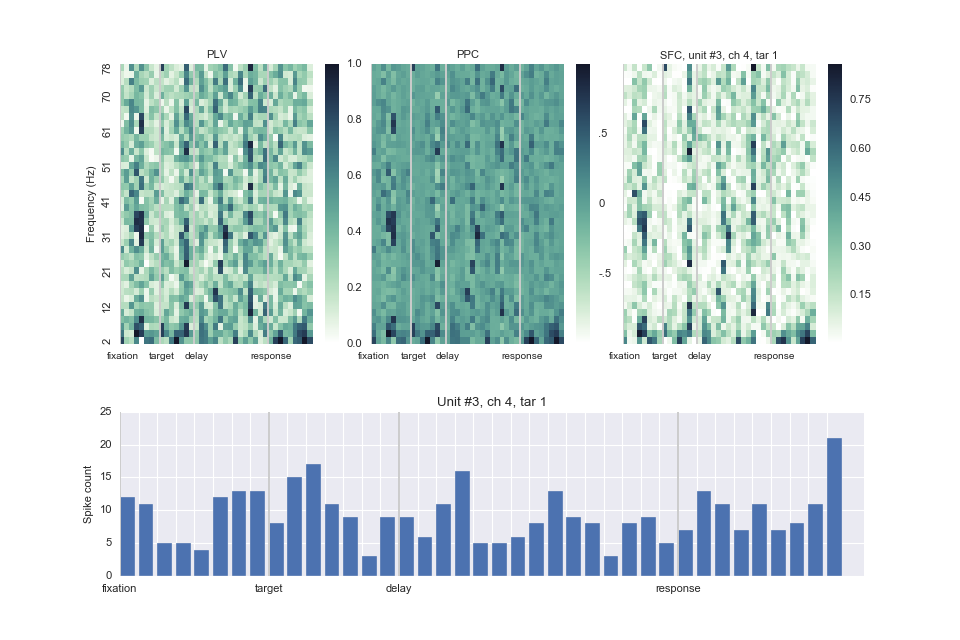

In [31]:
#fSF,(axPLV,axPPC, axSFC) = plt.subplots(1,3, sharey = True, figsize=(12, 5))
#fNSpikes, axNS = plt.subplots(1,1,figsize=(12,3))
fSF = plt.figure(figsize=(12,8))

# Spectrogram, explained variance, and p-value

In [32]:
## Display spectrogram, explained variance, and p-values of chosen channel
display(widgets.HBox((chMinus,chSlider,chPlus, button)))

<IPython.core.display.Javascript object>


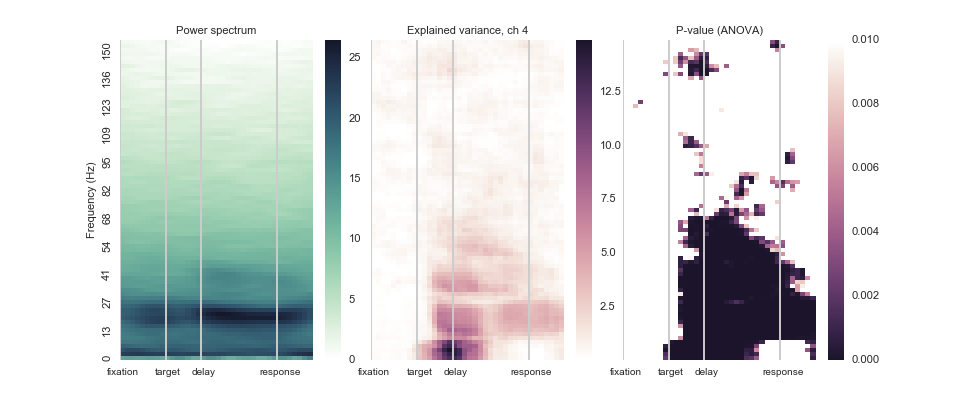

In [33]:
fPS,(axPS,axPSANOVA,axPSPVal) = plt.subplots(1,3, sharey = False, figsize=(12, 5))

In [34]:
display(widgets.HBox((chMinus,chSlider,chPlus)))
freqBand_button = widgets.ToggleButtons(
    #description = "Select band: ",
    options = [key for key in sorted(freqBands, key = lambda x: freqBands[x])],
    value = "beta"
)
display(freqBand_button)
display(psExpVarAllCh_button)

<IPython.core.display.Javascript object>


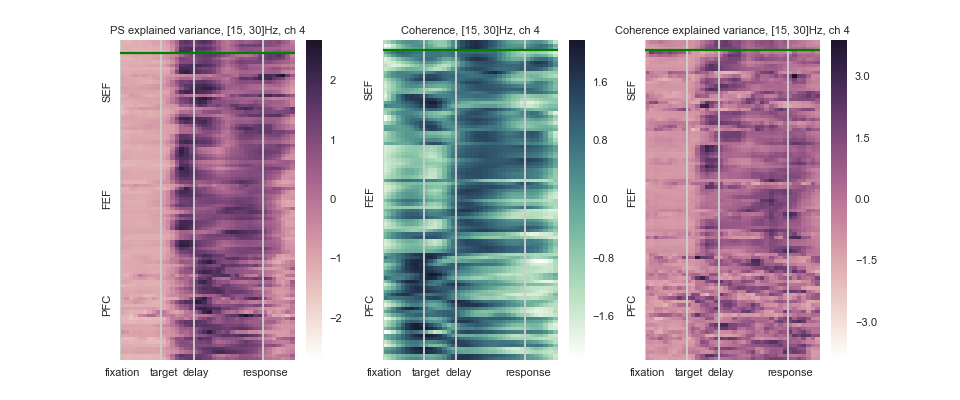

In [35]:
fPSExpVarAll,((axPSExpVarAll,axCohAll,axCohExpVarAll)) = plt.subplots(1,3, sharey = True, figsize=(12, 5))

# Coupling measure and explained variance by target location

In [37]:
## Display widget to pick coupling measure for chosen channel
display(widgets.HBox((fromChMinus_button,fromCh_slider,fromChPlus_button)),
        widgets.HBox((toChMinus_button,toCh_slider,toChPlus_button)))
display(chooseMeasure_button)
display(plot_measure_button)

<IPython.core.display.Javascript object>


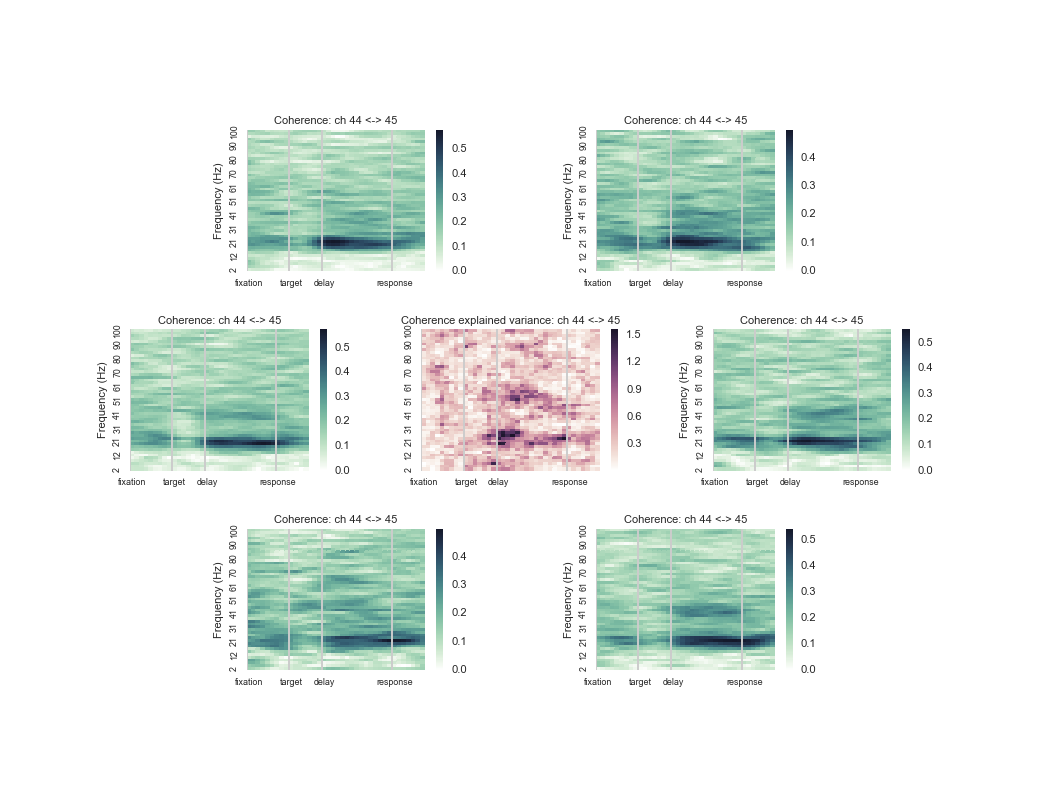

In [38]:
fAllTars = plt.figure(figsize=(13,10))